## Imports

In [105]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, uniform

# To hide warninigs
import warnings
warnings.filterwarnings('ignore')

In [106]:
my_guess = np.array([[0.5, 0.2, 0.3]])
T = np.array([[0.0, 1.0, 0.0],
              [0.0, 0.1, 0.9],
              [0.6, 0.4, 0.0]])

In [107]:
for i in range(100):
    my_guess = np.matmul(my_guess, T)
    #print(my_guess)

# Hand-made example of MCMC
We start with the results of an experiment. In this case we will generate fake data, following a normal distribution.
(this is what is coming from the experiments in the real life)

In [108]:
samples = norm(3.8,1).rvs(size=1000)

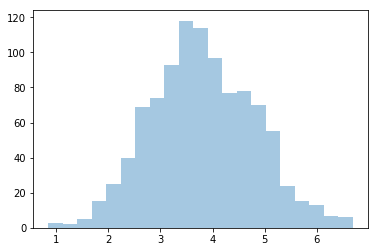

In [109]:
sns.distplot(samples, kde=False)

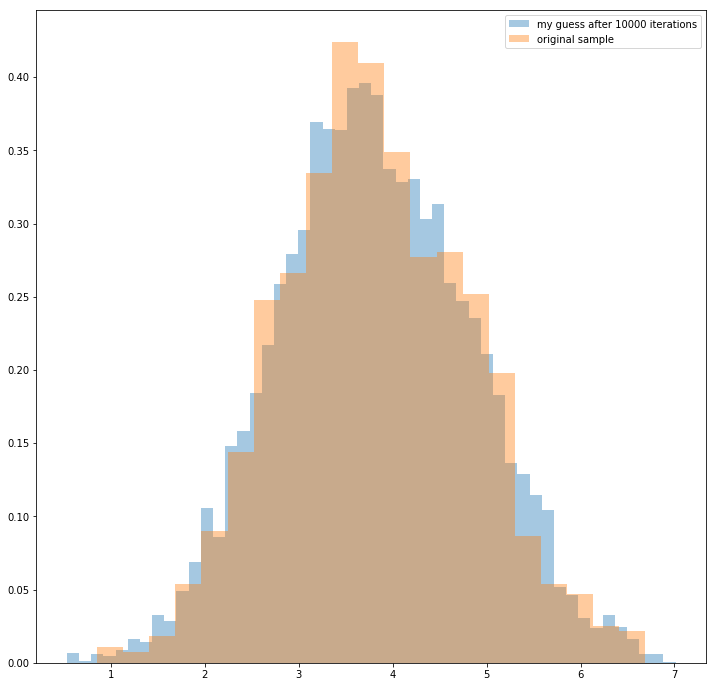

In [110]:

# I want to obtain the posterior distribution of my samples

iterations = 10000
standing_at = 3 # This is my initial guess of what the mean is, we can try with different values and see what happens
all_my_steps = [] # Just a record of what step I made each time 
all_my_standings = [] # Here I will record my posterior distribution,

for i in range(iterations):
    # I will move randomly, forward or backwards, at a maximun distance of 0.5
    step = uniform(0,1).rvs() - 0.5
    # The step that I will decide if I accept it or not
    candidate_standing_at = standing_at + step 
    
    p_actual_step = len([sample for sample in samples if standing_at - 0.5 < sample and sample < standing_at + 0.5]) / float(len(samples))
    p_candidate_step = len([sample for sample in samples if candidate_standing_at - 0.5 < sample and sample < candidate_standing_at + 0.5]) / float(len(samples))
    
    # If the new step is better, I always accept
    if p_candidate_step > p_actual_step:
        standing_at = candidate_standing_at
    else:
        # If not, I accept it randomly
        random_number = uniform(0,1).rvs()
        if random_number <= p_candidate_step / p_actual_step:
            standing_at = candidate_standing_at
            #print (standing_at, step)
    
    # I record my step and where I'm standing
    all_my_standings.append(standing_at)
    all_my_steps.append(step)

# If I plot all my standings, I will have the likelihood function of the mean of the data 
# (the parameter of the model that I'm inferring)
fig=plt.figure(figsize=(12, 12))
sns.distplot(all_my_standings, kde=False, label="my guess after %s iterations" % iterations, norm_hist=True)
# And I compare them with the original samples
sns.distplot(samples, kde=False, label="original sample", norm_hist=True)
plt.legend()
#sns.distplot(all_my_steps, kde=False)

# Using pymc3 to infer parameters from models

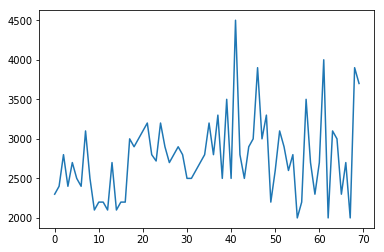

In [135]:
import pymc3 as pm

# I load my data
hpf_data = np.loadtxt("data/hpf.csv")

plt.plot(hpf_data)

In [113]:
# Then I create my parametric model (making initial guesses)
with pm.Model() as model:
    alpha1 = 1.0/hpf_data.mean()  
    alpha2 = 1.0/hpf_data.mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha1)
    lambda_2 = pm.Exponential("lambda_2", alpha2)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(hpf_data) - 1)

# This says that the random variable lambda_ is equal to lambda_1 if bigger than tau or lambda_2 otherwise
with model:
    idx = np.arange(len(hpf_data)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

# We add the observations to the model
with model:
    observation = pm.Poisson("obs", lambda_, observed=hpf_data)

In [160]:
# Now is the moment to sample with MCMC and the Metropolis algorithm
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 15000/15000 [00:04<00:00, 3229.89it/s]


In [161]:
# In the trace variable, I have a dictionary with the historical values of each one of the parameters
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

## histograms of the traces

Text(0.5,0,'$\\lambda_1$ value')

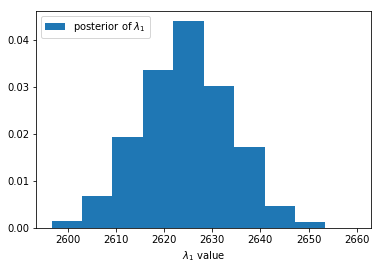

In [162]:
plt.hist(lambda_1_samples, label="posterior of $\lambda_1$", normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_1$ value")

Text(0.5,0,'$\\lambda_2$ value')

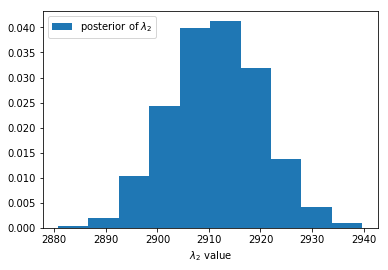

In [163]:
#histogram of the samples:

plt.hist(lambda_2_samples, label="posterior of $\lambda_2$", normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")



Text(0.5,0,'$\tau$ value')

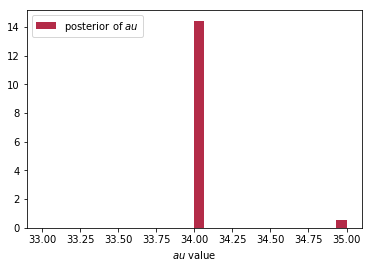

In [164]:
plt.hist(tau_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\tau$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\tau$ value")


# A more readable graphic

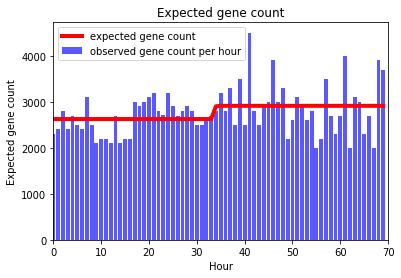

In [165]:
N = tau_samples.shape[0]
expected_hpf_data = np.zeros(len(hpf_data))
for hour in range(0, len(hpf_data)):
    
    ix = hour < tau_samples
    
    # Each posterior sample corresponds to a value for tau. For each hour, that value of tau indicates whether we're 
    # in the lambda1 "regime" or in the lambda2 "regime".
    #
    # Dy taking the posterior sample of lambda 1 or 2 accordingly, we can average
    # over all samples to get an expected gene count value for lambda on that hour.
    #
    # Observe that the "gene count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of it.
    expected_hpf_data[hour] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

    
plt.plot(range(len(hpf_data)), expected_hpf_data, lw=4, color="red",
         label="expected gene count")
plt.xlim(0, len(hpf_data))
plt.xlabel("Hour")
plt.ylabel("Expected gene count")
plt.title("Expected gene count")
plt.bar(np.arange(len(hpf_data)), hpf_data, color="blue", alpha=0.65,
        label="observed gene count per hour")

plt.legend(loc="upper left")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


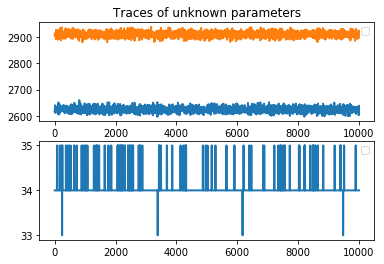

In [166]:
plt.subplot(211)

plt.title("Traces of unknown parameters")

plt.plot(lambda_1_samples, lw=2)
plt.plot(lambda_2_samples, lw=2)
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(212)

plt.plot(tau_samples, lw=2)

plt.legend();